In [1]:
import csv
import pandas as pd
from glob import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Prepare data

In [2]:
task_files = glob("task*.csv")

In [3]:
def format_data(data):
    result = []
    for i in data:
        r = [k.strip(",") for k in i.strip("\n").strip(" ").strip(",").split(":")]
        r[1] = float(r[1])
        result.append(r)
    return result

In [4]:
def prepare_data(task_files):
    tasks = {t: open(t) for t in task_files}
    raw_data = {t: v.readlines() for t, v in tasks.items()}
    data_dict = [{
        "file_name": n,
        "test_name": i[1].strip("\n").strip(".").strip("Test Name:,"),
        "data": format_data(i[2:])
    } for n, i in raw_data.items()]
    data_dict = sorted(data_dict, key=lambda x: x["file_name"])
    print("Test types:\n", set([i['test_name'] for i in data_dict]))
    print("")
    print("File Names:\n", list([i['file_name'] for i in data_dict]))
    return data_dict

In [5]:
data_dict = prepare_data(task_files)

Test types:
 {'4.12.0-patch', '4.12.0-config', '4.12.0-standard', '4.15.0-101-generic'}

File Names:
 ['task1-1.csv', 'task1-2.csv', 'task1-3.csv', 'task1-4.csv', 'task2-1.csv', 'task2-2.csv', 'task2-3.csv', 'task2-4.csv', 'task3-1.csv', 'task3-2.csv', 'task3-3.csv', 'task3-4.csv', 'task4-1.csv', 'task4-2.csv', 'task4-3.csv', 'task4-4.csv']


In [6]:
cols = [i[0] for i in data_dict[0]["data"]]

In [7]:
heat_map_data = [[j[1] for j in i["data"]] for i in data_dict]

In [8]:
relative_boost = [[v / heat_map_data[1][j] for j, v in enumerate(u)] for i, u in enumerate(heat_map_data)]

In [9]:
test_names = [i["test_name"] for i in data_dict]

In [10]:
file_name = [i["file_name"] for i in data_dict]

In [11]:
df = pd.DataFrame(heat_map_data, columns=cols)
df["test_names"] = test_names
df["file_name"] = file_name
df
absolute_df = df

In [12]:
df = pd.DataFrame(relative_boost, columns=cols)
df["test_names"] = test_names
df["file_name"] = file_name
df
relative_df = df

In [17]:
absolute_df.head(3)

,ref kbest,ref average,cpu kbest,cpu average,getpid kbest,getpid average,send kbest,send average,recv kbest,recv average,...,epoll kbest,epoll average,select big kbest,select big average,poll big kbest,poll big average,epoll big kbest,epoll big average,test_names,file_name
0,2.800000e-08,4.400000e-08,0.003085,0.003653,5.300000e-07,5.430000e-07,8.920000e-07,0.000002,0.000001,0.000002,...,0.000002,0.000002,0.000115,0.000126,0.000126,0.000137,0.000149,0.000168,4.15.0-101-generic,task1-1.csv
1,2.800000e-08,3.100000e-08,0.003085,0.003103,5.270000e-07,5.390000e-07,8.950000e-07,0.000002,0.000001,0.000002,...,0.000002,0.000002,0.000116,0.000128,0.000125,0.000138,0.000148,0.000168,4.15.0-101-generic,task1-2.csv
2,2.800000e-08,4.300000e-08,0.003085,0.003653,5.280000e-07,5.380000e-07,8.970000e-07,0.000002,0.000001,0.000002,...,0.000002,0.000002,0.000114,0.000127,0.000125,0.000137,0.000149,0.000167,4.15.0-101-generic,task1-3.csv


In [18]:
absolute_df.to_csv("result-absolute.csv")

In [19]:
relative_df.to_csv("result-relative.csv")

In [20]:
intask_df = [absolute_df[absolute_df["file_name"].str.contains(f"task{i}-")] for i in range(1,5)]

In [21]:
crosstask_df = [absolute_df[absolute_df["file_name"].str.contains(f"-{i}.csv")] for i in range(1,5)]

In [22]:
a = crosstask_df[0]

In [23]:
b = [a[i] for i in a.columns]
x = [1,2,3,4]

In [24]:
a

,ref kbest,ref average,cpu kbest,cpu average,getpid kbest,getpid average,send kbest,send average,recv kbest,recv average,...,epoll kbest,epoll average,select big kbest,select big average,poll big kbest,poll big average,epoll big kbest,epoll big average,test_names,file_name
0,2.800000e-08,4.400000e-08,0.003085,0.003653,5.300000e-07,5.430000e-07,8.920000e-07,0.000002,1.178000e-06,0.000002,...,1.725000e-06,1.962000e-06,0.000115,0.000126,0.000126,0.000137,0.000149,0.000168,4.15.0-101-generic,task1-1.csv
4,2.800000e-08,3.300000e-08,0.003085,0.003117,7.700000e-08,8.100000e-08,3.550000e-07,0.000001,4.810000e-07,0.000002,...,7.850000e-07,9.110000e-07,0.000051,0.000059,0.000065,0.000073,0.000088,0.000101,4.12.0-standard,task2-1.csv
8,2.800000e-08,3.200000e-08,0.003085,0.003108,7.800000e-08,8.100000e-08,3.590000e-07,0.000001,4.830000e-07,0.000001,...,7.820000e-07,9.180000e-07,0.000052,0.000058,0.000064,0.000074,0.000088,0.000101,4.12.0-patch,task3-1.csv
12,2.800000e-08,3.200000e-08,0.003085,0.003120,8.000000e-08,8.400000e-08,3.290000e-07,0.000001,4.810000e-07,0.000002,...,7.790000e-07,9.310000e-07,0.000054,0.000063,0.000068,0.000076,0.000092,0.000106,4.12.0-config,task4-1.csv


In [25]:
len(b)

86

In [26]:
import re

In [29]:
# name = iterate_set[4].name.replace("average", "-average").replace("kbest", "-kbest")
# name.find(" -")
# re.sub("[ ]*[-](average)$", "-average", name)
# re.sub("[ ]*[-](kbest)$", "-kbest", name)

In [31]:
# for i, k in enumerate(iterate_set):
#     name = k.name
#     name = re.sub("[ ]*(average)$", " (average)", name)
#     name = re.sub("[ ]*(kbest)$", " (kbest)", name)
#     print(name)

AttributeError: This method only works with the ScalarFormatter

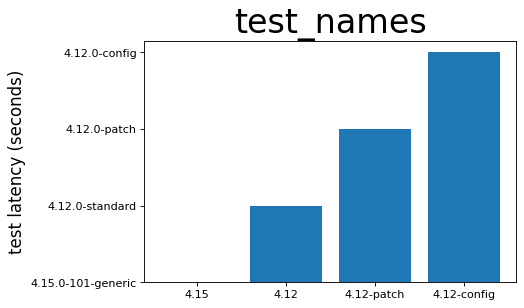

In [54]:
# import math
# iterate_set = b[:12]
# iterate_len = len(iterate_set)
# FIG_ROW = 3
# FIG_COL = int(math.ceil(iterate_len/FIG_ROW))
# for i, k in enumerate(iterate_set):
#     ax = plt.subplot(FIG_ROW, FIG_COL, i+1)
#     p = ax.bar(x, k)
# #     ax.xaxis.set_label_text(k.name)
#     ax.set_title(k.name.replace(" ", "-", 1).replace(" ", ""))

dpi = 80
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi

import matplotlib as mpl
mpl.rc("savefig", dpi=dpi)

iterate_set = b
xtick_index = [1, 2, 3, 4]
xtick_labels = ["4.15","4.12","4.12-patch","4.12-config"]

iterate_set = iterate_set
for i, k in enumerate(iterate_set):
    name = k.name
    name = re.sub("[ ]*(average)$", " (average)", name)
    name = re.sub("[ ]*(kbest)$", " (kbest)", name)
    name = name.replace(" ", "-")
    title_name = name.replace("-(average)", "").replace("-(kbest)", "")
    
    fig = plt.figure();
    plt.bar(x, k);
    plt.title(title_name, fontsize=30);
    plt.ylabel(
        "test latency (seconds)", fontsize=15)
    plt.xticks(
        [1,2,3,4], xtick_labels,
    )
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    fig.savefig(f"{i}-{name}.png");
    plt.close(fig)

In [35]:
def get_numeric_cols(a):
    return a[[i for i in list(a.columns) if i not in ["test_names", "file_name"]]]

In [36]:
def get_normalized(a, normalized_idx=0):
    b = get_numeric_cols(a)
    p = b[normalized_idx:normalized_idx+1].sum()
    c = b.subtract(p).div(p).mul(100).round()
    return c

In [37]:
correct_column_order = [
'context siwtch          kbest',
'context siwtch        average',

'small read          kbest',
'small read        average',
'mid read          kbest',
'mid read        average',
'big read          kbest',
'big read        average',
'huge read          kbest',
'huge read        average',


'small write          kbest',
'small write        average',
'mid write          kbest',
'mid write        average',
'big write          kbest',
'big write        average',
'huge write          kbest',
'huge write        average',


'small mmap          kbest',
'small mmap        average',
'mid mmap          kbest',
'mid mmap        average',
'big mmap          kbest',
'big mmap        average',
'huge mmap          kbest',
'huge mmap        average',


'small munmap          kbest',
'small munmap        average',
'mid munmap          kbest',
'mid munmap        average',
'big munmap          kbest',
'big munmap        average',
'huge munmap          kbest',
'huge munmap        average',


'fork          kbest',
'fork       average',
'fork    Child kbest',
'fork Child average',
'big fork          kbest',
'big fork       average',
'big fork    Child kbest',
'big fork Child average',
'huge fork          kbest',
'huge fork       average',
'huge fork    Child kbest',
'huge fork Child average',

'thr create          kbest',
'thr create       average',
'thr create    Child kbest',
'thr create Child average',

'send          kbest',
'send        average',
'recv          kbest',
'recv        average',
'big send          kbest',
'big send        average',
'big recv          kbest',
'big recv        average',




'select          kbest',
'select        average',
'poll          kbest',
'poll        average',
'epoll          kbest',
'epoll        average',

'select big          kbest',
'select big        average',
'poll big          kbest',
'poll big        average',
'epoll big          kbest',
'epoll big        average',

'small page fault          kbest',
'small page fault        average',
'mid page fault          kbest',
'mid page fault        average',
'big page fault          kbest',
'big page fault        average',
'huge page fault          kbest',
'huge page fault        average',

'ref          kbest',
'ref        average',
'cpu          kbest',
'cpu        average',
'getpid          kbest',
'getpid        average',
]

In [38]:
a = crosstask_df[0]

In [39]:
b = crosstask_df[1:]

In [40]:
a.T.head()

,0,4,8,12
ref kbest,2.8e-08,2.8e-08,2.8e-08,2.8e-08
ref average,4.4e-08,3.3e-08,3.2e-08,3.2e-08
cpu kbest,0.00308454,0.00308459,0.00308459,0.00308458
cpu average,0.00365277,0.00311658,0.00310848,0.00312007
getpid kbest,5.3e-07,7.7e-08,7.8e-08,8e-08


In [41]:
normalized = get_normalized(crosstask_df[0], normalized_idx=1)
normalized = normalized[correct_column_order]

In [42]:
normalized.T.head()

,0,4,8,12
context siwtch kbest,72.0,0.0,-0.0,-0.0
context siwtch average,64.0,0.0,0.0,1.0
small read kbest,167.0,0.0,-1.0,4.0
small read average,151.0,0.0,0.0,4.0
mid read kbest,20.0,0.0,-1.0,1.0


In [43]:
normalized_avg = normalized[
    [i for i in normalized.columns if i.find("average") >= 0]
]

In [44]:
dpi = 100
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi

import matplotlib as mpl
mpl.rc("savefig", dpi=dpi)

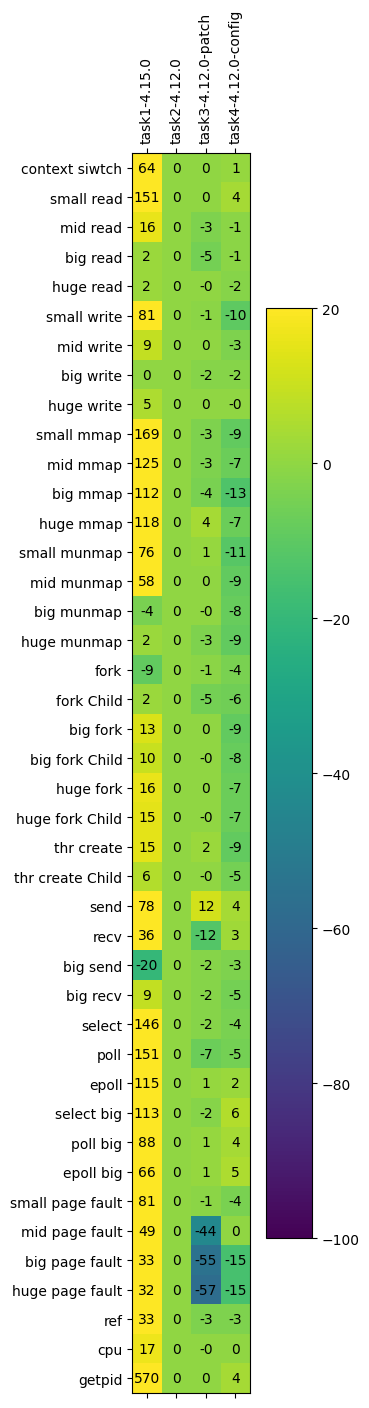

In [45]:
plt.matshow(
    normalized_avg.T, 
    interpolation='nearest',
    vmax=20, vmin=-100
)

xlabels = [str(i) for i in [
    "task1-4.15.0",
    "task2-4.12.0",
    "task3-4.12.0-patch",
    "task4-4.12.0-config"
]]

ylabels = [i.split("average")[0].strip(" ") for i in normalized_avg.columns]

plt.xticks(np.arange(len(xlabels)), xlabels, rotation='vertical')
plt.yticks(np.arange(len(ylabels)), ylabels)

plt.colorbar()

for (i, j), z in np.ndenumerate(normalized_avg.T):
    plt.text(
        j, i, '{:0.0f}'.format(z), ha='center', va='center', 
#              color='w'
            )